### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import qlearner as ql
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import data
import rnn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

### Set theme for plots

In [2]:
# Set seaborn style
rc_defaults = {'figure.titlesize': 24, 'axes.labelsize': 20,
               'xtick.labelsize': 20, 'ytick.labelsize': 20,
               'lines.linewidth': 3}
sns.set_theme(style='ticks', rc=rc_defaults)

### Simulate data

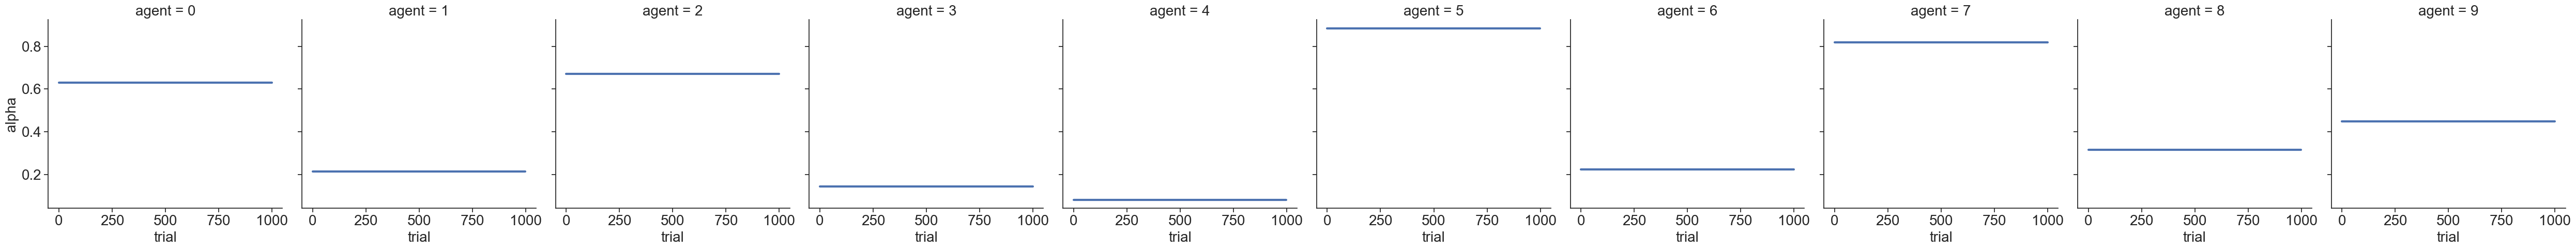

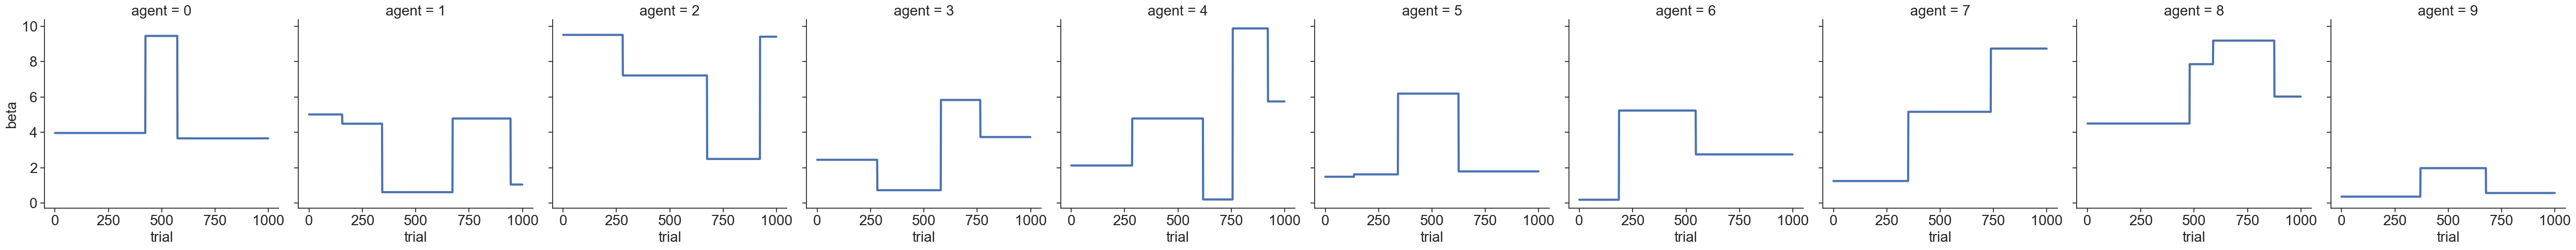

In [3]:
# Number of agents
train_nagents = 20
test_nagents = 10

# Number of trials per agent
ntrials = 1000

# Number of trials per block
block_size = 100

# Variables to save in synthetic data
columns = ['agent', 'trial', 'block', 'action', 'reward', 'offer1', 'offer2', 'alpha', 'beta', 'alpha_bin', 'beta_bin']

# Initialize list to store training data
train_data = []

for agent in range(0, train_nagents):
    # Set parameters
    alpha_gen = ql.ParamGeneratorStat(name='alpha', func=np.random.uniform, low=0, high=1, ntrials=ntrials)
    beta_gen = ql.ParamGeneratorNonStat(name='beta', func=np.random.uniform, low=0, high=10, ntrials=ntrials,
                                        max_switch=np.random.choice([2, 3, 4]), prob_to_switch=0.005)

    # Simulate data for agent
    qlearner = ql.QLearner4Armed(agent, alpha_gen=alpha_gen, beta_gen=beta_gen, ntrials=ntrials, block_size=block_size).simulate()
    
    # Append data to list
    train_data.append(qlearner.format_df(columns=columns))

# Concatenate training data into one dataframe
df_train_data = pd.concat(train_data).reset_index().drop(columns=['index'])

# Save data
fname = os.path.join('data', f'synth_train_4armed.csv')
df_train_data.to_csv(fname, index=False)

# Initialize list to store test data
test_data = []

for agent in range(0, test_nagents):
    # Set parameters
    alpha_gen = ql.ParamGeneratorStat(name='alpha', func=np.random.uniform, low=0, high=1, ntrials=ntrials)
    beta_gen = ql.ParamGeneratorNonStat(name='beta', func=np.random.uniform, low=0, high=10, ntrials=ntrials,
                                        max_switch=np.random.choice([2, 3, 4]), prob_to_switch=0.005)

    # Simulate data for agent
    qlearner = ql.QLearner4Armed(agent, alpha_gen=alpha_gen, beta_gen=beta_gen,
                                 ntrials=ntrials, block_size=block_size).simulate()

    # Append results to list
    test_data.append(qlearner.format_df(columns=columns))

# Concatenate test data into one dataframe
df_test_data = pd.concat(test_data).reset_index().drop(columns=['index'])

# Save data
fname = os.path.join('data', 'synth_test_4armed.csv')
df_test_data.to_csv(fname, index=False)

# Inspect test data of first 10 agents
for param in ['alpha', 'beta']:
    sns.relplot(data=df_test_data[df_test_data['agent'].isin(np.arange(10))],
            kind='line', x='trial', y=param, col='agent')

### Train and evaluate model

In [ ]:
# CPU or GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DL dataset for training
ds = data.LabeledDataset(inputs=['action', 'offer', 'reward'],
                         outputs=['action', 'alpha_bin', 'beta_bin', 'alpha', 'beta'],
                         path=os.path.join('data', 'synth_train_4armed.csv'))

# Instantiate RNN model
model = rnn.GRU(ds, hidden_size=32, dropout=0.2) 

# Train RNN model
model, train_loss, val_loss = rnn.training_loop(ds, model, device, nepochs=5, fname='synth_trnn_4armed')

# Create DL dataset for test
ds = data.LabeledDataset(inputs=['action', 'offer', 'reward'], outputs=['alpha', 'beta'], df=df_test_data)

# Instantiate Data Loader for test data
test_loader = DataLoader(ds, shuffle=False, batch_size=1)

# Instantiate RNN model
model = rnn.GRU(ds, hidden_size=32, dropout=0)

# Load checkpoint for model inference
cp = torch.load(os.path.join('checkpoint', 'synth_trnn_4armed_train.pth'),
                  map_location='cpu')
print(f"Number of epochs in training: {cp['epoch']}")

# Assign model state
model.load_state_dict(cp['model_state'])

# Change to evaluation mode
model.eval()

# Initialize loss objects
loss_obj = {'alpha': rnn.Loss('MSE', weight=1), 'beta': rnn.Loss('MSE', weight=1)}

# Initialize losses as numpy arrays
loss = np.zeros((ds.nagents, len(ds.outputs)))

# Initialize model predictions as numpy arrays
y_alpha = np.zeros((ds.nagents, ds.ntrials))
y_beta = np.zeros((ds.nagents, ds.ntrials))

# Evaluate model on test data
for i, (X, y_true) in enumerate(test_loader):
    # Forward pass
    model(X)
    
    # Save predictions for plotting
    y_alpha[i, :] = model.y['alpha'].flatten().tolist()
    y_beta[i, :] = model.y['beta'].flatten().tolist()
    
    # Compute losses
    loss[i, :] = [loss_obj[val](model.y[val], y_true[j]).item() for j, val in enumerate(loss_obj.keys())]

# Print losses
for i, val in enumerate(loss_obj.keys()):
    print(f"tRNN {loss_obj[val].name} {val} loss: {loss[:, i].mean():.5f} +/- {loss[:, i].std():.5f}")

### Plot parameter recovery

In [ ]:
# Collect targets and predictions in a dataframe
df_recovery = pd.concat([df_test_data[['agent', 'trial', 'alpha', 'beta']].assign(data='Target'),
                         df_test_data[['agent', 'trial']].assign(data='t-RNN', alpha=y_alpha.flatten(), beta=y_beta.flatten())])

# Plot parameter recovery for alpha
g = sns.relplot(data=df_recovery[df_recovery['agent'].isin(np.arange(3))],
                kind='line', x='trial', y='alpha', col='agent', hue='data',
                height=1.5, aspect=2.2)
g.set(xlim=(0, ntrials), ylim=(-0.2, 1.4));

# Plot parameter recovery for beta
g = sns.relplot(data=df_recovery[df_recovery['agent'].isin(np.arange(3))],
                kind='line', x='trial', y='beta', col='agent', hue='data',
                height=1.5, aspect=2.2)
g.set(xlim=(0, ntrials), ylim=(-0.1, 10.1));